# Homework 3

# Amol Dattatray Sangar (asangar)

## P1: DCT and PCA [5 points]

<div class="alert alert-info">
1. I like walking in the B-Line trail (although it doesn’t mean that I have time to walk there frequently). IMG 1878.JPG is the photo I took there. Load it and divide the 3D array (1024 × 768 × 3) into the three channels. Let’s call them XR, XG, and XB.
<br/>
<br/>
2. Randomly choose a block of 8 consecutive (entire) rows from XR, e.g. XR (113:120,1:768) (See the red box in Figure 1). This will be a matrix of 8×768. Collect another 2 such blocks, each of which starts from a randomly chosen first row position. Move on to the green channel and extract another three 8×768 blocks. Blue channel, too. You collected 9 blocks from all three channels. Now, concatenate all of them horizontally. This will be a matrix of 8×6912 pixels. Let’s call it R.
<br/>
<br/>
3. Subtract the mean vector of size 8 × 1 from all 6912 vectors.
<br/>
<br/>
4. Calculate the covariance matrix, which will be an 8 × 8 matrix.
<br/>
<br/>
5. Do eigendecomposition on the covariance matrix (feel free to use a toolbox) and extract 8 eigenvectors, each of which is with 8 dimensions. Yes, you did PCA. Imagine that you convert the original 8×6912 matrix into the other space using the learned eigenvectors. For example, if your eigenvector matrix is W, than W⊤R will do it. Plot your W⊤ and compare it to the DCT matrix shown in M02-S21. Similar? Submit your plot and code.
<br/>
</div>

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import random
import numpy as np
import math

In [2]:
# read image to array
im = np.array(Image.open('data/IMG_1878.jpg'))

In [3]:
im.shape

(1024, 768, 3)

In [4]:
Xr = im[:, :, 0]
Xg = im[:, :, 1]
Xb = im[:, :, 2]

In [5]:
def collect_random_blocks(data, no_of_blocks_per_channel):
    R = []

    for i in range(0,len(data)):
        for _ in range(0,no_of_blocks_per_channel):
            rand_x = np.random.randint(0,1024-8)
            R.append(data[i][rand_x:rand_x+8])
    
    R = np.array(R)

    return np.concatenate(R, axis = 1)

In [6]:
def eigen_decomposition(R):
    R = R - np.mean(R, axis = 1).reshape(-1,1)
    cov_mat = np.dot(R, R.T) * (1/R.shape[1]-1)
    
    W = np.linalg.eigh(cov_mat)[1]
    
    return W

In [7]:
data = [Xr, Xg, Xb]

In [8]:
R1 = collect_random_blocks(data, 3)
R1.shape

(8, 6912)

In [9]:
R2 = collect_random_blocks(data, 30)
R2.shape

(8, 69120)

In [10]:
R1_eigen_vector = eigen_decomposition(R1)
R2_eigen_vector = eigen_decomposition(R2)

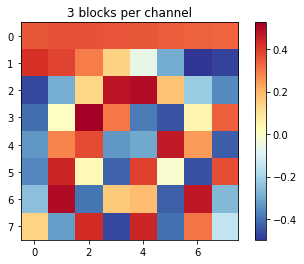

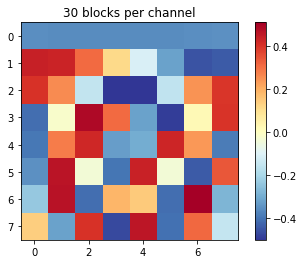

In [11]:
plt.title("3 blocks per channel")
plt.imshow(R1_eigen_vector.T, cmap = 'RdYlBu_r')
plt.colorbar()
plt.show()

plt.title("30 blocks per channel")
plt.imshow(R2_eigen_vector.T, cmap = 'RdYlBu_r')
plt.colorbar()
plt.show()

### Comparing both plots, we can see that the plot using 90 samples has captured higher variances than the plot using 9 samples

## P2: Instantaneous Source Separation [6 points]

In [12]:
import librosa as lb
from IPython.display import Audio

C:\Users\AMOL\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
C:\Users\AMOL\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps, copy_X=True, fit_path=True,

#### Loading audio file

In [13]:
audio = []
file_start = 1
file_end = 4

for i in range(file_start,file_end+1):
    fs, sr = lb.load('data/x_ica_' + str(i) + '.wav', sr = None)
    audio.append(np.array(fs))
    
audio = np.array(audio)

In [14]:
audio.shape

(4, 42292)

#### Zero centering audio data

In [15]:
audio_mean = np.mean(audio, axis=1).reshape(-1,1)
audio_zero_centered = np.array(audio - audio_mean)

audio_covariance = np.dot(audio_zero_centered, audio_zero_centered.T) * (1/(audio_zero_centered.shape[1] - 1))

In [16]:
audio_covariance.shape

(4, 4)

#### Eigen decomposition

In [17]:
# Calculating 's', 'u' and the contribution of one eigen vector
def calc_su(X, w):
    s1 = np.sqrt(np.sum(np.dot(w.T,X)**2))
    u1 = np.dot(X.T, w)/s1
    contrib = s1 * np.dot(w, u1.T)
    return s1, u1, contrib

def eigen_decomposition(X, num_of_eigenvectors, alpha, max_iterations):
    i = 0
    eigen_value = []
    eigen_vector = []
    
    for i in range(num_of_eigenvectors):
        # INITIALIZING w RANDOMLY
        w = np.random.rand(X.shape[0], 1)
        
        # NORMALIZING w
        denom = 0
        for i in range(num_of_eigenvectors):
            denom += w[i]**2
        w = w / np.sqrt(denom)
        
        for epoch in range(max_iterations):
            w = np.dot(X, w)
            w = w / np.sqrt(np.sum(w**2))    # L-2 NORMALIZATION
        
        s1, u1, contrib = calc_su(X, w)        
        
        # Removing the contribution of the eigen vector from the original matrix
        X = X - contrib
        
        eigen_value.append(s1)
        eigen_vector.append(w.reshape(-1,))

    eigen_vector = np.array(eigen_vector)

    return eigen_value, eigen_vector.T

In [18]:
eigen_value, eigen_vector = eigen_decomposition(audio_covariance, num_of_eigenvectors=4, alpha=0.0001, max_iterations=1000)

In [19]:
eigen_vector = eigen_vector * (1/np.sqrt(eigen_value))
Z = np.dot(eigen_vector.T, audio)

C:\Users\AMOL\Anaconda3\lib\site-packages\matplotlib\collections.py:874: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


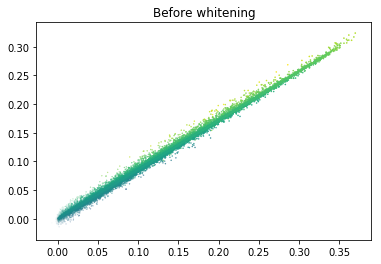

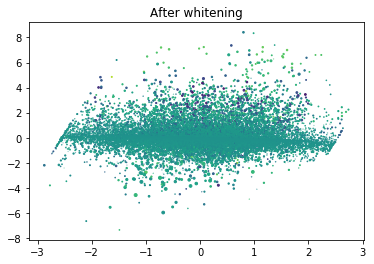

In [20]:
# SCATTER PLOTS
plt.scatter(audio[0], audio[1], audio[2], audio[3])
plt.title('Before whitening')
plt.show()

plt.scatter(Z[0], Z[1], Z[2], Z[3])
plt.title('After whitening')
plt.show()

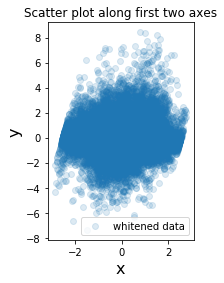

In [21]:
fig = plt.figure(figsize=(12,4))
plt.subplot(1,4,3)
plt.title('Scatter plot along first two axes')
plt.scatter(Z[0], Z[1], label='whitened data', alpha=0.15)
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.legend()

### The data has been successfully whitened as the plot is almost circular in shape

#### Independent Component Analysis

In [22]:
def ICA(Z, N, learning_rate, max_iterations):
    delta_W = np.identity(4)
    W = np.identity(4)
    Y = np.dot(W,Z)        # 4 × (Z source matrix)
    convergence = []

    for i in range(0, max_iterations):
        delta_W = np.dot((N*np.identity(4) - np.dot(np.tanh(Y),(Y**3).T)), W)
        W = W + learning_rate*delta_W
        Y = np.dot(W,Z)
        convergence.append(np.sum(np.abs(delta_W)))

    return W, convergence

In [23]:
W, convergence = ICA(Z, N=Z.shape[1], learning_rate=0.000001, max_iterations=1000)
separated_audio = np.dot(W, Z)

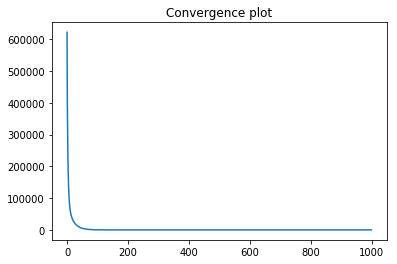

In [24]:
plt.title('Convergence plot')
plt.plot(convergence)
plt.show()

---
### Transcript 1: 'Motorcycle Audio'

In [25]:
Audio(separated_audio[0,:], rate = sr)

---
### Transcript 2: I ate every Oyster on Nora's plate

In [26]:
Audio(separated_audio[1,:], rate = sr)

---
### Transcript 3: It's not easy to create illuminating examples

In [27]:
Audio(separated_audio[2,:], rate = sr)

---
### Transcript 4: Twenty two or Twenty three

In [28]:
Audio(separated_audio[3,:], rate = sr)

---

## P3: Ideal Masks [4 points]

<div class="alert alert-info">
    
1. piano.wav and ocean.wav are two sources you’re interested in. Load them separately and apply STFT with 1024 point frames and 50% overlap. Use Hann windows. Let’s call these two spectrograms S and N, respectively. Discard the complex conjugate part, so eventually they will be an 513 × 158 matrix1. Later on in this problem when you recover the time domain signal out of this, you can easily recover the discarded half from the existing half so that you can do inverse-DFT on the column vector of full 1024 points. Hint: Why 513, not 512? Create a very short random signal with 16 samples, and do a DFT transform to convert it into a spectrum of 16 complex values. Check out their complex coefficients to see why you need N/2 + 1, not N/2. I will allow you to use other implementations, such as librosa.stft, but I strongly encourage you to reuse your code from Homework 2.
<br/>
<br/>
2. Now you build a mixture spectrogram by simply adding the two source spectrograms: X = S +N. Note that all the numbers here are complex values. 
<br/>
<br/>
3. Since you know the sources, the source separation job is trivial. One way is to calculate the ideal masks M = S S+N (once again, note that they are all complex valued and the division is element-wise). By the definition of the mixture spectrogram, S =M⊙X, where ⊙ stands for a Hadamard product. But we won’t use this one today.
<br/>
<br/>
4. Sometimes we can only estimate a nonnegative real-valued masking matrix ¯M especially if we don’t have an access to the phase of the sources. For example, ¯M = |S|^2 / |S|^2+|N|^2 . Go ahead and calculate ¯M from your sources, and multiply it to your mixture spectrogram, i.e. S ≈ ¯M ⊙ X. Convert your estimated piano spectrogram back to the time domain. Submit the .wav file of your recovered piano source.
<br/>
<br/>
5. Listen to the recovered source. Is it too different from the original? One way to objectively measure the quality of the recovered signal is to compare it to the original signal by using a metric called Signal-to-Noise Ratio (SNR): Evaluate the SNR between piano.wav and your reconstruction for it. Note: their lengths could be slightly different. Just ignore the small difference in the end.
<br/>
<br/>
6. Yet another masking scheme is something called Ideal Binary Masks (IBM). This time, we use a binary (0 or 1) masking matrix B, which is definded by
Bft =  1 if |S|ft > |N|ft
0 otherwise
<br/>
<br/>
7. Create your IBM from the sources, and apply it to your mixture spectrogram, S ≈ B ⊙ X. Do the inverse STFT. How does it sound? What’s its SNR value?
<br/>
<br/>
8. Don’t forget to create audio players for the sound examples in your iPython (i.e., jupyter or Google Colab) notebook. Check if they play sound in the .html version.
</div>

In [29]:
piano, srp = np.array(lb.load('data/piano.wav', sr = None), dtype=object)
ocean, sro = np.array(lb.load('data/ocean.wav', sr = None), dtype=object)

In [30]:
piano.shape

(80000,)

In [31]:
piano_stft = lb.core.stft(piano)
ocean_stft = lb.core.stft(ocean)

S = piano_stft[:513,:]
N = ocean_stft[:513,:]

#### Mixture Spectogram

In [32]:
X = S + N

#### Mixture Signal

In [33]:
recovered_mix_signal = lb.core.istft(X)
Audio(recovered_mix_signal, rate = 8000)

### Real-valued Masking

In [34]:
masking_mat_M = (np.abs(S)**2)/((np.abs(S)**2)+(np.abs(N)**2))
S_recover = np.multiply(masking_mat_M, X)

In [35]:
recovered_piano_signal = lb.core.istft(S_recover)
Audio(recovered_piano_signal, rate = 8000)

#### Piano Signal-to-Noise Ratio (SNR)

In [36]:
def piano_SNR(recovered_signal):
    SNR = 10 * np.log10(np.sum((piano[:39936])**2) / np.sum((piano[:39936] - recovered_signal)**2))
    return SNR

In [37]:
SNR = piano_SNR(recovered_piano_signal)
print('SNR: ' + str(np.abs(SNR)))

SNR: 5.213069915771484


### Ideal Binary Masks (IBM) Masking

In [61]:
condition = S > N
masking_mat_B = np.array(condition, dtype=int)

In [62]:
S_ibm = np.multiply(masking_mat_B, X)

In [63]:
recovered_piano_signal_ibm = lb.core.istft(S_ibm)
Audio(recovered_piano_signal_ibm, rate = 8000)

In [57]:
SNR_ibm = piano_SNR(recovered_piano_signal_ibm)
print('SNR: ' + str(np.abs(SNR_ibm)))

SNR: 4.287460987820465


### Since SNR for real-valued masking is higher than IBM masking, it performs better in seperating the two sources which is evident from the audio samples